In [1]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle
import pandas as pd

# Helper functions

In [99]:
def plot_hist(returns):
    
    zeta = 0.05
    alpha = 0.05
    
    sns.kdeplot(returns)
    
    p = np.mean(returns >= zeta)
    var = np.quantile(returns, alpha)
    cvar = float(np.sum(returns * (returns <= var)) / np.sum(returns <= var)) / (1 - alpha)

    plt.axvline(var, c='y', linestyle='--', label=f'VaR={var:4.2}')
    plt.axvline(cvar, c='r', linestyle='--', label=f'CVaR={cvar:4.2}')
    plt.axvline(zeta, c='g', linestyle='--', label=f'P={p}')
    plt.legend()

In [200]:
def plot_2d(returns):
    
    n_assets = returns.shape[1]
    
    fig, ax = plt.subplots(nrows=n_assets, ncols=n_assets, figsize=(2 * n_assets + 2, 2 * n_assets), constrained_layout=True)
    fig.suptitle('2D marginals', fontsize=20)

    for i in range(n_assets):
        for j in range(n_assets):
            if i < j:
                ax[i][j].hist2d(returns[:, i], returns[:, j], bins=50, range=[[-0.3, 0.3], [-0.3, 0.3]], cmap='viridis')
            if i > j:
                fig.delaxes(ax[i][j])
        sns.kdeplot(data=returns[:, i], ax=ax[i][i], fill=True, label='train')
        ax[i][i].legend()

# Generate returns

In [203]:
T = 60
Rx = 100.
Ry = 1000.
batch_size = 1_000

kappa = [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
sigma = [1, 0.3, 0.5, 1.5, 1.75, 2, 2.25]
p = [0.35, 0.3, 0.34, 0.33, 0.32, 0.31, 0.3]
phi = np.repeat(0.03, 7)

In [204]:
''' Initial reserves '''
Rx0   = np.repeat(Rx, len(kappa))
Ry0   = np.repeat(Ry, len(kappa))

pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

xs_0 = np.repeat(1., len(kappa))
l = pools.swap_and_mint(xs_0)
end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 306.90it/s]


In [205]:
x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
log_ret = np.log(x_T)
Y = pd.DataFrame(log_ret)
Y

,0,1,2,3,4,5,6
0,0.122025,0.116686,0.048463,0.245949,0.023739,-0.012226,-0.025507
1,0.034121,0.106392,0.105596,-0.044332,0.048976,0.027175,-0.008116
2,0.162135,0.208111,0.208098,0.092356,0.435918,0.057627,0.046931
3,0.059867,0.059264,0.090531,0.179215,0.070934,0.076374,0.024655
4,0.026939,0.102779,0.131703,0.138014,-0.064966,0.113365,0.052575
...,...,...,...,...,...,...,...
995,0.149026,0.020132,-0.012374,-0.005499,0.447212,0.114421,-0.023418
996,0.083498,0.065458,0.110610,0.051960,-0.001202,-0.093434,0.020373
997,0.075643,0.147368,0.068195,0.047879,0.030614,0.029274,-0.005356
998,0.104959,0.124638,0.057567,0.094630,0.231169,0.077525,0.046023


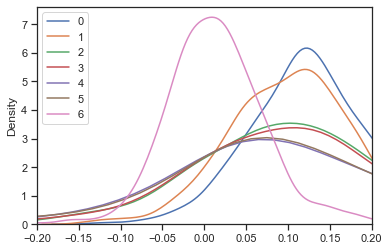

In [206]:
# 1d marginals on top of each other

for i in range(log_ret.shape[1]):
    sns.kdeplot(log_ret[:, i], label=i)
    
plt.xlim((-0.2, 0.2))
plt.legend()

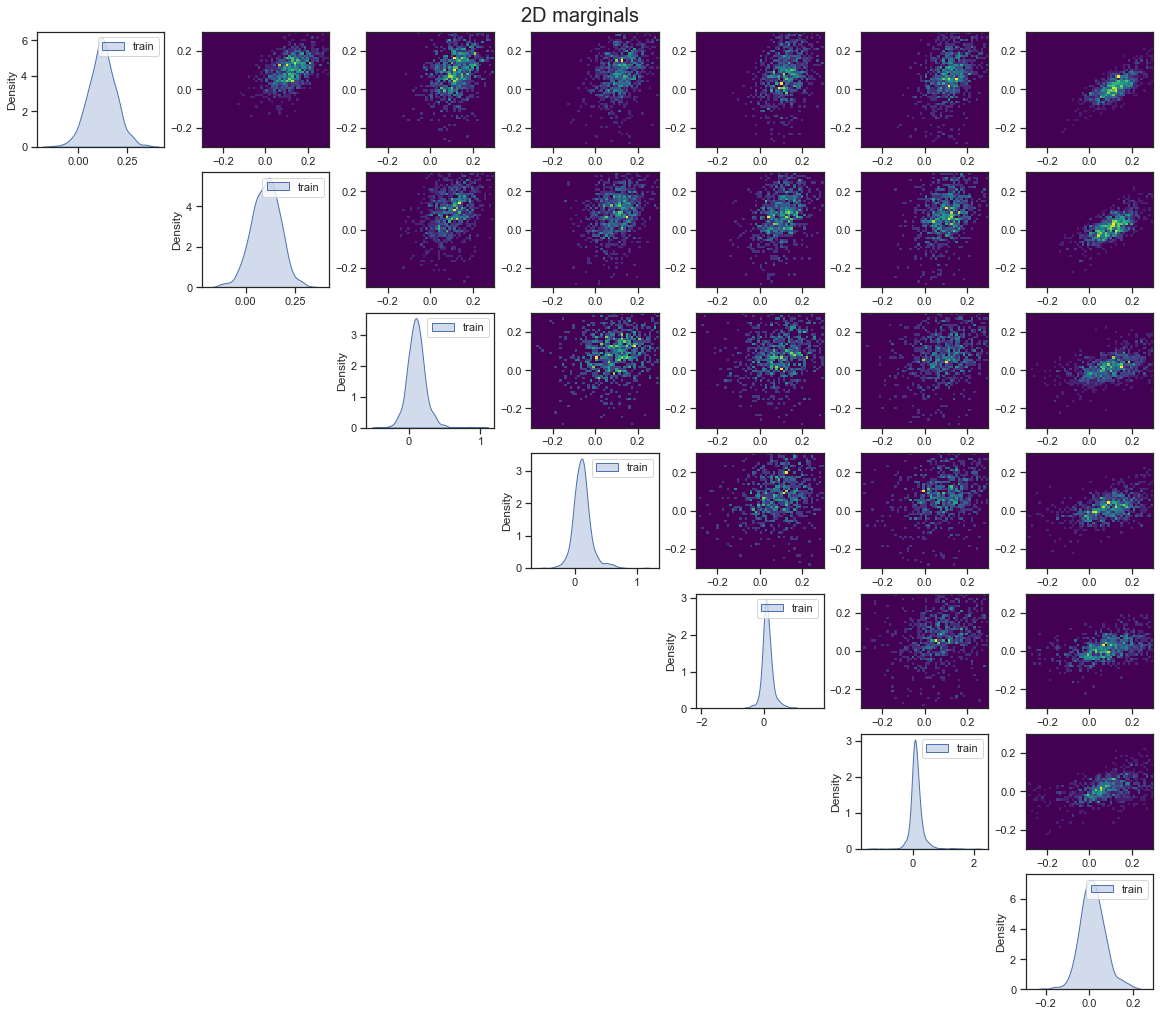

In [207]:
plot_2d(log_ret)

In [208]:
df = pd.DataFrame(log_ret)
mean = pd.DataFrame(df.mean(axis=0)).T
display(mean.style.background_gradient(cmap='coolwarm', axis=None))
corr = df.corr()
display(corr.style.background_gradient(cmap='coolwarm', axis=None))

,0,1,2,3,4,5,6
0,0.122929,0.101613,0.108210,0.111400,0.105180,0.114036,0.014018


,0,1,2,3,4,5,6
0,1.000000,0.507061,0.278043,0.301071,0.248494,0.206038,0.738256
1,0.507061,1.000000,0.275699,0.234395,0.203766,0.183886,0.691200
2,0.278043,0.275699,1.000000,0.132883,0.127465,0.115099,0.386425
3,0.301071,0.234395,0.132883,1.000000,0.134355,0.108038,0.364983
4,0.248494,0.203766,0.127465,0.134355,1.000000,0.104268,0.295782
5,0.206038,0.183886,0.115099,0.108038,0.104268,1.000000,0.272300
6,0.738256,0.691200,0.386425,0.364983,0.295782,0.272300,1.000000


# Optimization with riskfolio

In [6]:
import riskfolio as rp
import pandas as pd

Portfolio weights:


,0,1,2,3,4,5,6
weights,0.538431,0.263887,0.131116,2.494234e-11,0.066566,3.129740e-14,8.917373e-14


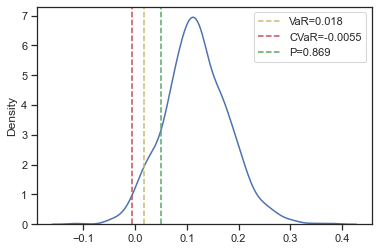

In [118]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

print("Portfolio weights:")
display(weights.T)

portfolio_returns = log_ret @ weights
portfolio_returns = portfolio_returns.to_numpy().T[0]
plot_hist(portfolio_returns)

# Optimization by hand

1. Adjust code from `riskfolio/src/Portfolio.py`, and incorporate our constraints P(ret >= 0.5) >= 0.7
2. Check if this constraint can be accommodated by riskfolio library

Objective: 117.32064694407967
Portfolio weights:


,0,1,2,3,4,5,6
0,0.497126,0.239083,0.117557,0.0374,0.072356,0.023185,0.013294


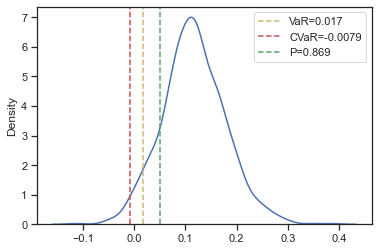

In [156]:
# pseudocode:
# reference file: riskfolio/src/Portfolio.py

import cvxpy as cp
import numpy as np

returns = log_ret
alpha = 0.05

n_returns, n_assets = returns.shape

weights = cp.Variable((n_assets, 1))
k = cp.Variable((1, 1))
var = cp.Variable((1, 1))
Z1 = cp.Variable((n_returns, 1))
log_w = cp.Variable((n_assets, 1))

X = returns @ weights
cvar = var + 1 / (alpha * n_returns) * cp.sum(Z1)

# CVaR constraints
constraints = [Z1 * 1000 >= 0, Z1 * 1000 >= -X * 1000 - var * 1000]

constraints += [
    # rb.T @ cp.log(w) >= 1,
    np.ones((1, n_assets)) @ log_w >= 1,
    cp.ExpCone(log_w * 1000, np.ones((n_assets, 1)) * 1000, weights * 1000),
    weights * 1000 >= 0,
    cp.sum(weights) * 1000 == k * 1000,
]

objective = cp.Minimize(cvar * 1000)

# naive idea for the return constraint:
# constraints += [cp.sum(returns @ weights >= 0.05) >= 0.7 * n_returns]

# possible solvers: "ECOS", "SCS", "OSQP", "CVXOPT"
prob = cp.Problem(objective, constraints)
result = prob.solve(solver="SCS")

print(f"Objective: {result}")

portfolio_weights = (weights.value / k.value).T[0]
portfolio_returns = returns @ portfolio_weights

print("Portfolio weights:")
display(pd.DataFrame(portfolio_weights).T)
plot_hist(portfolio_returns)